## This is notebook exploring camera calibration challenge 
 - If you want to use the baseline model provided in the repo, you need to install all the libraries. 
 - I work in conda and created a soccernet environment where I installed the necessary versions of torch, etc. 
 - The notebook mostly follows the baseline code provided in the official repo with some additional graphics the explain what's going on. 

In [1]:
import copy
import json
import os.path
import random
from collections import deque
from pathlib import Path

import cv2 as cv
import glob as glob
import numpy as np
import torch
import torch.backends.cudnn
import torch.nn as nn
from PIL import Image
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm import tqdm

from src.soccerpitch import SoccerPitch
from src.baseline_extremities import (generate_class_synthesis, join_points, get_line_extremities, get_support_center, synthesize_mask)
from src.baseline_extremities import SegmentationNetwork
%matplotlib inline
from matplotlib import pyplot as plt
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

In [2]:
lines_palette = [0,0,0]
for line_class in SoccerPitch.lines_classes:
    lines_palette.extend(SoccerPitch.palette[line_class])

In [3]:
# This is the image segmentation network provided in the repo. 
calib_net = SegmentationNetwork(
    "resources/soccer_pitch_segmentation.pth",
    "resources/mean.npy",
    "resources/std.npy")

In [96]:
mainDir = "/Volumes/T7/datasets/Netv3/trackingVid"
dataset_dir = mainDir + '/test'

allVideos = sorted(glob.glob(dataset_dir + "/*/combined25FPS.mp4"))

In [97]:
# You can choose a different image from the data. I'll use frame_index throughout the whole notebook
vidIdx  = 0
frameIdx = 100

thisVid = allVideos[vidIdx]
thisVid = "/Volumes/T7/datasets/Netv3/trackingVid/challenge/SNMOT-022/combined25FPS.mp4"
cap = cv.VideoCapture(thisVid)
cap.set(cv.CAP_PROP_POS_FRAMES,frameIdx)

print(f"Cap is at index {cap.get(cv.CAP_PROP_POS_FRAMES)}")
ret, image = cap.read()
print(f"Cap is at index {cap.get(cv.CAP_PROP_POS_FRAMES)}")

frame_index_int = cap.get(cv.CAP_PROP_POS_FRAMES)

prediction = dict()
count = 0


print(image.shape)


Cap is at index 100.0
Cap is at index 101.0
(1080, 1920, 3)


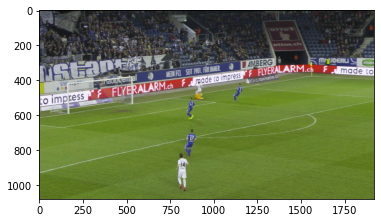

In [98]:
#Show the image with matplotlib
# This is the image for which we'll be trying to find field lines and camera calibration
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.show()

In [99]:
# This command finds the segmented field lines. 
semlines = calib_net.analyse_image(image)
# The network returns an image dimension(360, 640), with values from 0..25. Each int value corresponds to the particular field line
semlines.shape, semlines.dtype, np.unique(semlines)

((360, 640),
 dtype('uint8'),
 array([ 0,  2,  3,  8, 10, 11, 12, 20, 22, 23, 24, 25], dtype=uint8))

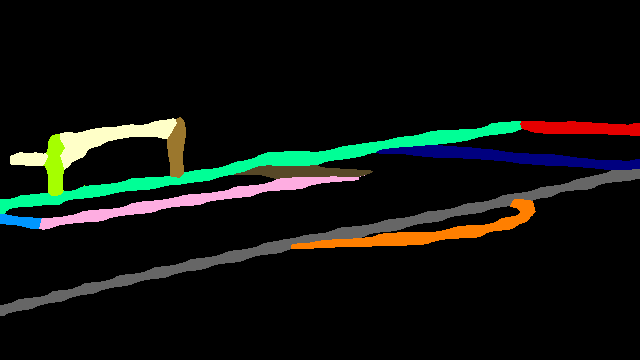

In [100]:
#Assigning each field line a separate color based on the palette provided in the code. 
mask = Image.fromarray(semlines.astype(np.uint8)).convert('P')
mask.putpalette(lines_palette)
mask

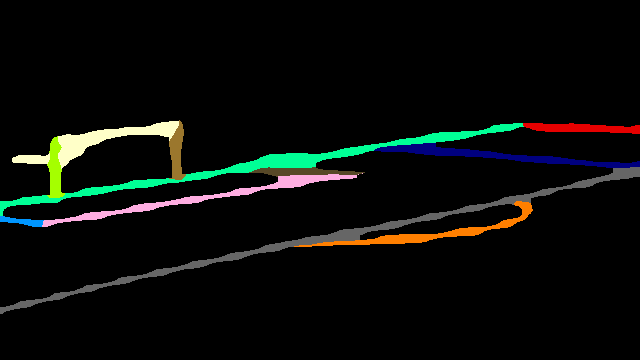

In [101]:
kernel = np.ones((5, 5), np.uint8)
semantic_mask = cv.erode(semlines, kernel, iterations=1)
mask = Image.fromarray(semantic_mask.astype(np.uint8)).convert('P')
mask.putpalette(lines_palette)
mask

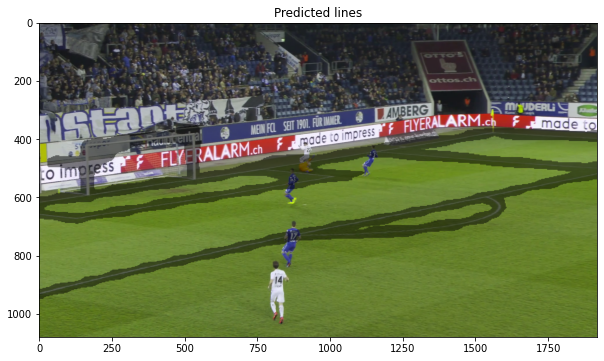

In [116]:
# Overlay the mask with the image
image_bkg = cv.cvtColor(image, cv.COLOR_BGR2RGB)
field_lines = cv.resize(semlines, (image.shape[1], image.shape[0]))
field_lines[field_lines>0] = 125
image_bkg[field_lines>0] = image_bkg[field_lines>0]//2
#Show the image with matplotlib
plt.figure(figsize= (10,15))
plt.title('Predicted lines')
plt.imshow(image_bkg)
plt.show()
# As we can see some mistakes include other lines(not field lines) included in one of the categories. ---> Area to improve

 - Next we have some code that uses the segmentation data to find line extremities. 
 - All the code is taken from the baseline in the repo. 
 - We do not need to use it to find extremities but it's a good starting point. 

In [117]:
skeletons = generate_class_synthesis(semlines, 6)

We included ['Big rect. left main', 'Big rect. left top', 'Circle left', 'Goal left crossbar', 'Goal left post left ', 'Goal left post right', 'Side line left', 'Side line top', 'Small rect. left bottom', 'Small rect. left main', 'Small rect. left top']


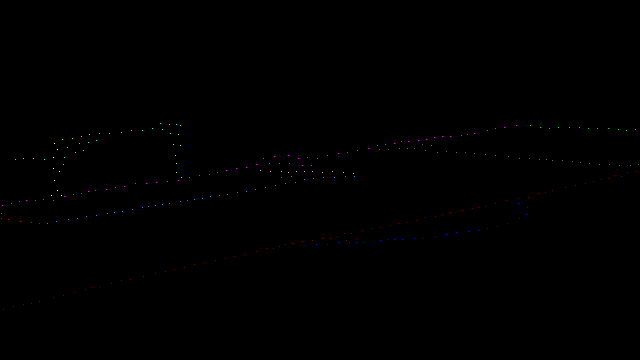

In [118]:
# Visualize skeletons.
skeletons_vis = np.zeros(semlines.shape).astype('uint8')
for k, class_name in enumerate(SoccerPitch.lines_classes):
    if class_name in skeletons.keys():
        for xy in skeletons[class_name]:
            skeletons_vis[xy[0], xy[1]] = k

skeletons_vis = Image.fromarray(skeletons_vis).convert('P')
skeletons_vis.putpalette(lines_palette)
skeletons_vis

In [119]:
resolution_width = 640
resolution_height = 360
extremities = get_line_extremities(skeletons, 40, resolution_width, resolution_height)

In [120]:
extremities

{'Big rect. left main': [{'x': 0.0046875, 'y': 0.8583333333333333},
  {'x': 0.99375, 'y': 0.475}],
 'Big rect. left top': [{'x': 0.5921875, 'y': 0.41388888888888886},
  {'x': 0.996875, 'y': 0.45555555555555555}],
 'Circle left': [{'x': 0.809375, 'y': 0.5638888888888889},
  {'x': 0.4765625, 'y': 0.6805555555555556}],
 'Goal left crossbar': [{'x': 0.265625, 'y': 0.36944444444444446},
  {'x': 0.0234375, 'y': 0.44166666666666665}],
 'Goal left post left ': [{'x': 0.0796875, 'y': 0.5416666666666666},
  {'x': 0.084375, 'y': 0.3972222222222222}],
 'Goal left post right': [{'x': 0.28125, 'y': 0.3472222222222222},
  {'x': 0.2828125, 'y': 0.49166666666666664}],
 'Side line left': [{'x': 0.0015625, 'y': 0.5916666666666667},
  {'x': 0.80625, 'y': 0.3472222222222222}],
 'Side line top': [{'x': 0.9921875, 'y': 0.35833333333333334},
  {'x': 0.828125, 'y': 0.3472222222222222}],
 'Small rect. left bottom': [{'x': 0.0609375, 'y': 0.6194444444444445},
  {'x': 0.0015625, 'y': 0.6055555555555555}],
 'Small

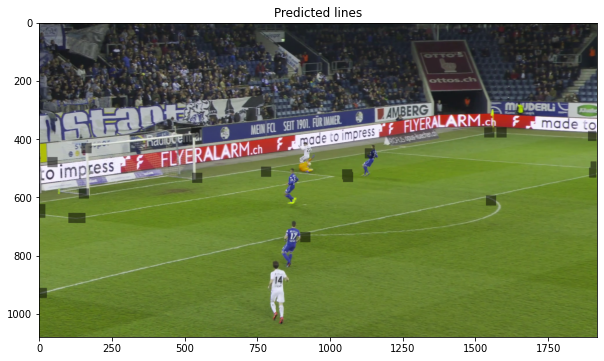

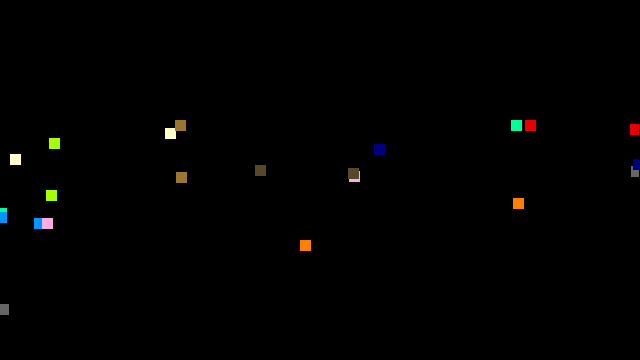

In [121]:
# Visualize extremities. Mark each point with a square of size 2*w + 1 and overlay over main image

w = 5
extremities_vis = np.zeros(semlines.shape).astype('uint8')
for k, class_name in enumerate(SoccerPitch.lines_classes):
    if class_name in extremities.keys():
        for xy in extremities[class_name]:
            y = int(xy['y']*resolution_height)
            x = int(xy['x']*resolution_width)
            extremities_vis[max(y-w,0):min(y+w+1,resolution_height-1), max(x-w,0):min(x+w+1,resolution_width-1) ] = k+1

           
image_bkg = cv.cvtColor(image, cv.COLOR_BGR2RGB)
extremities_overlay = cv.resize(extremities_vis, (image.shape[1], image.shape[0]))
extremities_overlay[extremities_overlay>0] = 125
image_bkg[extremities_overlay>0] = image_bkg[extremities_overlay>0]//2
#Show the image with matplotlib
plt.figure(figsize= (10,15))
plt.title('Predicted lines')
plt.imshow(image_bkg)
plt.show()
            
            
            
extremities_vis = Image.fromarray(extremities_vis).convert('P')
extremities_vis.putpalette(lines_palette)
extremities_vis

In [122]:
# prediction_file = os.path.join(output_prediction_folder, f"extremities_{frame_index}.json")
# with open(prediction_file, "w") as f:
#     json.dump(extremities, f, indent=4)

### Evaluation
 - This is part 1 of the challenge. 
 - You get evaluated on how accurate are your extremities calculations

## Homography

 - Second part of the challenge 
 - Based on the image and extremities find camera parameters
 - Current baseline implementation only uses the extremities file to find camera calibration. We do not need to use only that. We could use other extracted information from the image. 

In [123]:
from src.camera import Camera
from src.soccerpitch import SoccerPitch
from src.baseline_cameras import normalization_transform #Computes the similarity transform such that the list of points is centered around (0,0) and that its distance to thecenter is sqrt(2).
from src.baseline_cameras import estimate_homography_from_line_correspondences
from src.baseline_cameras import draw_pitch_homography

In [124]:
def inBounds(point, margin=10):
    m = margin
    inX = 0+m < point[0] < resolution_width-m
    inY = 0+m < point[1] < resolution_height-m
    rr = inX and inY
    return rr

Big rect. left main ----  L_PENALTY_AREA_TR_CORNER:[  3. 309.   1.].  L_PENALTY_AREA_BR_CORNER:[636. 171.   1.]
Big rect. left top ----  L_PENALTY_AREA_TL_CORNER:[379. 149.   1.].  L_PENALTY_AREA_TR_CORNER:[638. 164.   1.]
Circle left ----  TL_16M_LINE_AND_PENALTY_ARC_INTERSECTION:[518. 203.   1.].  BL_16M_LINE_AND_PENALTY_ARC_INTERSECTION:[305. 245.   1.]
Goal left crossbar ----  L_GOAL_TR_POST:[170. 133.   1.].  L_GOAL_TL_POST:[ 15. 159.   1.]
Goal left post left  ----  L_GOAL_TL_POST:[ 51. 195.   1.].  L_GOAL_BL_POST:[ 54. 143.   1.]
duplication
Goal left post right ----  L_GOAL_TR_POST:[180. 125.   1.].  L_GOAL_BR_POST:[181. 177.   1.]
duplication
Side line left ----  TL_PITCH_CORNER:[  1. 213.   1.].  BL_PITCH_CORNER:[516. 125.   1.]
Side line top ----  TL_PITCH_CORNER:[635. 129.   1.].  TR_PITCH_CORNER:[530. 125.   1.]
duplication
Small rect. left bottom ----  L_GOAL_AREA_BL_CORNER:[ 39. 223.   1.].  L_GOAL_AREA_BR_CORNER:[  1. 218.   1.]
Small rect. left main ----  L_GOAL_AREA_T

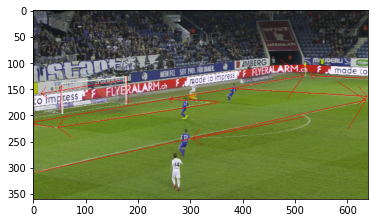

In [125]:
predictions = extremities
camera_predictions = dict()

cv_image = cv.resize(image, (resolution_width, resolution_height))

field = SoccerPitch()
line_matches = []
potential_3d_2d_matches = {}
src_pts = []

success = False
# For each prediction we attempt to find the corresponding line in the filed pitch schema. 
# Since we don't know which point in extremities is which end of the line, some points can have potential multiple matches
# You can uncomment some print statements to explore the loop

for k, v in predictions.items():
    if k == 'Circle central' or "unknown" in k:
        continue
    P3D1 = field.line_extremities_keys[k][0] # Dict key names of the two ends of the segment: one end
    P3D2 = field.line_extremities_keys[k][1]   #the other end of the segment, by name
    
    p1 = np.array([v[0]['x'] * resolution_width, v[0]['y'] * resolution_height, 1.]) #line extremities
    p2 = np.array([v[1]['x'] * resolution_width, v[1]['y'] * resolution_height, 1.])
    print(f'{k} ----  {P3D1}:{p1}.  {P3D2}:{p2}')
    if inBounds(p1, margin=20):
        src_pts.append(p1)
    if inBounds(p2, margin=20):
        src_pts.append(p2)
    if P3D1 in potential_3d_2d_matches.keys():
        potential_3d_2d_matches[P3D1].extend([p1, p2])
        print("duplication")
    else:
        potential_3d_2d_matches[P3D1] = [p1, p2]
    if P3D2 in potential_3d_2d_matches.keys():
        potential_3d_2d_matches[P3D2].extend([p1, p2])
    else:
        potential_3d_2d_matches[P3D2] = [p1, p2]

    start = (int(p1[0]), int(p1[1]))
    end = (int(p2[0]), int(p2[1]))
    cv.arrowedLine(cv_image, start, end, (0, 0, 255), 1)

    line = np.cross(p1, p2)
    if np.isnan(np.sum(line)) or np.isinf(np.sum(line)):
        continue
    line_pitch = field.get_2d_homogeneous_line(k) #line_pitch is the line on the field 2D coordinates. Excludes circle and goal posts
    if line_pitch is not None:
        line_matches.append((line_pitch, line))
        
for k, v in potential_3d_2d_matches.items():
   print(k,':', v)

plt.imshow(cv.cvtColor(cv_image, cv.COLOR_BGR2RGB))
# plt.imshow(cv_image)

In [126]:
if len(line_matches) >= 4:
    target_pts = [field.point_dict[k][:2] for k in potential_3d_2d_matches.keys()]
    T1 = normalization_transform(target_pts)
    T2 = normalization_transform(src_pts)
    success, homography = estimate_homography_from_line_correspondences(line_matches, T1, T2)
    if success:
        #cv_image = draw_pitch_homography(cv_image, homography)
        cam = Camera(resolution_width, resolution_height)      
        success = cam.from_homography(homography)
        if success:
            print('Succesfully estimate homography. First approximation camera parameters...')
            for k,v in cam.to_json_parameters().items():
                print(k,':', v)
            point_matches = []
            added_pts = set()
            for k, potential_matches in potential_3d_2d_matches.items():
                p3D = field.point_dict[k]
                projected = cam.project_point(p3D)

                if 0 < projected[0] < resolution_width and 0 < projected[1] < resolution_height:
                    dist = np.zeros(len(potential_matches))
                    for i, potential_match in enumerate(potential_matches):
                        dist[i] = np.sqrt((projected[0] - potential_match[0]) ** 2 + (
                                projected[1] - potential_match[1]) ** 2)
                    selected = np.argmin(dist)
                    if dist[selected] < 100:
                        point_matches.append((p3D, potential_matches[selected][:2]))

            if len(point_matches) > 3:
                print('\n\nFound > 3 point matches. Refining homography. New camera parameters are... ')
                cam.refine_camera(point_matches)
                for k,v in cam.to_json_parameters().items():
                    print(k,':', v)                
                # cam.draw_colorful_pitch(cv_image, SoccerPitch.palette)
                print("Would print image path image_path")
                # cv.imshow("colorful pitch", cv_image)
                # cv.waitKey(0)

if success:
    camera_predictions = cam.to_json_parameters()

# task2_prediction_file = os.path.join(output_prediction_folder, f"camera_{frame_index}.json")
if camera_predictions:
    # with open(task2_prediction_file, "w") as f:
    #     json.dump(camera_predictions, f, indent=4)
    pass

Succesfully estimate homography. First approximation camera parameters...
pan_degrees : -47.4730394765954
tilt_degrees : 81.95239832932323
roll_degrees : 3.632700726109607
position_meters : [0.21760655449279653, 43.903713668164826, -10.384804335755131]
x_focal_length : 1485.0283561271467
y_focal_length : 1485.0283561271951
principal_point : [320.0, 180.0]
radial_distortion : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
tangential_distortion : [0.0, 0.0]
thin_prism_distortion : [0.0, 0.0, 0.0, 0.0]


Found > 3 point matches. Refining homography. New camera parameters are... 
pan_degrees : -51.1950352305547
tilt_degrees : 82.17500594473728
roll_degrees : 2.268549172717342
position_meters : [7.361901741128719, 41.542651111358836, -10.207598523486883]
x_focal_length : 1485.0283561271467
y_focal_length : 1485.0283561271951
principal_point : [320.0, 180.0]
radial_distortion : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
tangential_distortion : [0.0, 0.0]
thin_prism_distortion : [0.0, 0.0, 0.0, 0.0]
Would print image pa

In [113]:
# Succesfully estimate homography. First approximation camera parameters...
# pan_degrees : 34.62596044872545
# tilt_degrees : 81.75532379567584
# roll_degrees : 2.0474180780674414
# position_meters : [4.779806891368249, 55.83919091121594, -9.739767239117437]
# x_focal_length : 1481.5413487800931
# y_focal_length : 1481.5413487801104
# principal_point : [320.0, 180.0]
# radial_distortion : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# tangential_distortion : [0.0, 0.0]
# thin_prism_distortion : [0.0, 0.0, 0.0, 0.0]
#
#
# Found > 3 point matches. Refining homography. New camera parameters are...
# pan_degrees : 35.51995719901801
# tilt_degrees : 81.68103203068117
# roll_degrees : 4.787892109009719
# position_meters : [6.028519868378524, 52.36682062548658, -10.870020576823986]
# x_focal_length : 1481.5413487800931
# y_focal_length : 1481.5413487801104
# principal_point : [320.0, 180.0]
# radial_distortion : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# tangential_distortion : [0.0, 0.0]
# thin_prism_distortion : [0.0, 0.0, 0.0, 0.0]
# Would print image path image_path

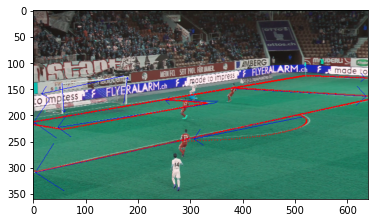

In [114]:
#Initial estimation of homography  based on line correspondences
plt.imshow(draw_pitch_homography(cv_image, homography))

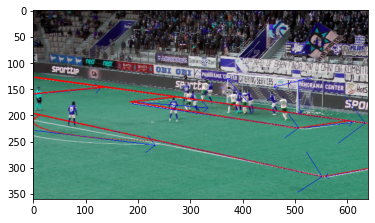

In [38]:
#Initial estimation of homography  based on line correspondences
plt.imshow(draw_pitch_homography(cv_image, homography))

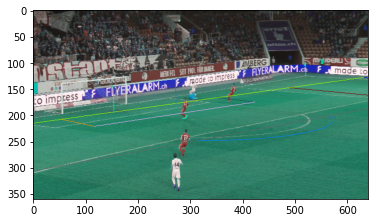

In [115]:
#Refined estimation of homography  based on line correspondences
cv_image = cv.resize(image, (resolution_width, resolution_height))
plt.imshow(cam.draw_colorful_pitch(cv_image, SoccerPitch.palette))

In [109]:
cap.release()